<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/leoenge/Lab-4/leoenge_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Function Approximation**
**Leo Enge**

# **Abstract**

The purpose of this lab is to do function approximations by linear lagrange functions in both one dimension and two dimensions over finite space meshes. The algoritms worked well and the error of the approximations decresed as the number of mesh points was increased.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Leo Enge (leoe@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.


'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad, dblquad

# **Introduction**

In this lab we calculate function approximations by linear lagrange functions on finite space meshes.


# **Methods**

## L2 projection in 1D
We will do the L2 projection on the global basis of hat functions to enforce continouity. 

For every node $x_i$ in the mesh, there will be exactly one such global basis function $\phi_i$ which is $1$ in that node. This function will also be zero in all other nodes. We therefore index the functions in such a way that
\begin{equation}
\phi_i(x_i) = 1
\end{equation}
We do not use any local basis function since there is only "one basis function per node". We iterate over theses basis functions and calculate the appropriate inner products to populate the matrix $A = (a_{ij})$, where $a_{ij} = (\phi_j,\phi_i)$ and the vector $b$, where $b_i = (f, \phi_i)$

The inner products $(\phi_i, \phi_j)$ is calculated by the rules
\begin{align}
(\phi_i, \phi_i) &= \frac{x_i - x_{i-1}}{3} + \frac{x_{i+1} - x_{i}}{3}\\
(\phi_i, \phi_{i+1}) &= \frac{x_{i+1} - x_{i}}{3}
\end{align}
and $(\phi_i, \phi_j) = 0$ if $|i-j|>1$.

After we have iterated over all the basis functions and have populated the matrix $A$ and the vector $b$, we then solve the system $A\alpha = b$ and return $\alpha$.

Note that $\alpha$ will be the values of the function approximation in each of the mesh nodes.

In [0]:
def l2_projection_1d(f, mesh):
  n = mesh.size
  A = np.zeros((n, n))
  b = np.zeros(n)

  intervals = mesh[1:]-mesh[:-1]
  A[0,0] = intervals[0]/3
  A[0,1] = intervals[0]/6
  A[n-1,n-1] = intervals[n-2]/3
  A[n-1,n-2] = intervals[n-2]/6
  b[0] = quad(lambda x: f(x)*(mesh[1]-x)/intervals[0], mesh[0], mesh[1])[0]
  b[n-1] = quad(lambda x: f(x)*(x-mesh[n-2])/intervals[n-2], mesh[n-2], mesh[n-1])[0]
  for i in range(1, n-1):
    A[i,i] = (intervals[i-1] + intervals[i])/3
    A[i,i+1] = intervals[i]/6
    A[i,i-1] = intervals[i-1]/6
    b[i] += quad(lambda x: f(x)*(x-mesh[i-1])/intervals[i-1], mesh[i-1], mesh[i])[0]
    b[i] += quad(lambda x: f(x)*(mesh[i+1]-x)/intervals[i], mesh[i], mesh[i+1])[0]
  return np.linalg.solve(A,b)

### Test 1D
We test the L2 approximation for a set of different functions and mesh sizes. We then calculate a vector of the error of the function approximation compare to the real function in each of the mesh nodes. This is calculated as 
\begin{equation}
error = alpha - f(mesh).
\end{equation}

We would now like a measure on how large this error is, but using the norm of the error vector will not be very good as we increase the mesh size since the length of the error vector will also increase, even thoug the general error hopefully decreases. 

We instead use the measure "norm per element" which is just $\|v\|/n$, where $n$ is the length of the vector.

In [0]:
def test_1d():
  print('==== Test of the \"norm per element\" for some functions ====')
  functions = [["f(x) = x^2",lambda x: x**2], ["f(x) = x^3", lambda x: x**3], ["f(x) = sin(x)", lambda x: np.sin(2*np.pi*x)]]
  for f_name,f in functions:
    print('\n======= NEW FUNCTION =======\n')
    print(f_name)
    for mesh_size in [10, 20, 50, 100, 1000]:
      print('====')
      print('mesh_size = ' + str(mesh_size))
      mesh = np.linspace(0,5, num=mesh_size)
      alpha = l2_projection_1d(f, mesh)
      error = alpha-f(mesh)
      print('error norm per element = ' + str(norm_per_element(error)))

  print('\n\n==== Example for the function f(x) = sin(x) and the mesh size 20\n')
  mesh = np.linspace(0,5, num=20)
  alpha = l2_projection_1d(lambda x: np.sin(x), mesh) 
  error = alpha - np.sin(mesh)
  print("The error P_Nf(x)-f(x) in the mesh-points:")
  print(error)
  print('\n\n')
  x = np.linspace(0,5, num=1000)
  plt.plot(x, np.sin(x))
  plt.plot(mesh, alpha, '*')
  plt.title('Plot of projected function in mesh points against the real function.')

def norm_per_element(vector):
  return np.linalg.norm(vector)/vector.size

## L2 projection in 2D
For the L2 projection we need a couple of subroutines.

### Lagrange polynomials
We define a function which is the $i$-th linear Lagrange polynomial on the mesh-triangle defined by the three points $p_0, p_1$ and $ p_2$. This function returns the value of the lagrange function evaluated at the point $p$ in the mesh-triangle.

In [0]:
def lagrange_2d(i, p, p0, p1, p2):
  if i == 0:
    return ((p1[1]-p2[1])*(p[0]-p2[0]) + (p2[0]-p1[0])*(p[1]-p2[1]))/((p1[1]-p2[1])*(p0[0]-p2[0]) + (p2[0]-p1[0])*(p0[1]-p2[1]))
  elif i == 1:
    return ((p2[1]-p0[1])*(p[0]-p2[0]) + (p0[0]-p2[0])*(p[1]-p2[1]))/((p1[1]-p2[1])*(p0[0]-p2[0]) + (p2[0]-p1[0])*(p0[1]-p2[1]))
  elif i == 2:
    return 1 - lagrange_2d(0, p, p0, p1, p2) - lagrange_2d(1, p, p0, p1, p2)

### Integrate over an arbitrary triangle
We define a function which integrates a function $f(x,y)$ over the integral defined by the points $p_0, p_1$ and $ p_2$. This is done by making a change of variables suggested by the user _Christian Blatter_ on StackOverflow (url: https://math.stackexchange.com/questions/954409/double-integral-over-an-arbitrary-triangle)

In [0]:
def integrate_triangle(f, p0, p1, p2):
  g1 = lambda u,v: p0[0] + u*(p1[0] - p0[0]) + v*(p2[0] - p0[0])
  g2 = lambda u,v: p0[1] + u*(p1[1] - p0[1]) + v*(p2[1] - p0[1]) 
  detJ = (p1[0] - p0[0])*(p2[1] - p0[1]) - (p2[0] - p0[0])*(p1[1] - p0[1])
  return dblquad(lambda u,v: f(g1(u,v), g2(u,v)), 0, 1, lambda x: 0, lambda x: 1-x)[0]

### The L2 projection algorithm
Just as in the 1D-case, there will be one basis function $\phi_i$ which is $1$ in each of the vertices $x_i$ of the mesh. So we can index the basis functions by which node it is $1$ in. I.e. we set the indicies of the basis functions such that
\begin{equation}
\phi_i(x_i) = 1.
\end{equation}
We will then also have that $\phi_i(x_j) = 0$ for all $j \neq i$. This index $i$ is the global index of the basis functions.

On each mesh there is three linear lagrange-functions $\lambda_0, \lambda_1$ and $\lambda_2$, which each is a part of some global basis function $\phi_i$.

In the algorithm we iterate over all the triangles in the mesh and calculate all the inner products $(\lambda_i, \lambda_j)$ for the local $i,j = 0,1,2$ and then add it to the entry of the corresponding inner product in the matrix $A = (a_{lk})$, where $a_{lk} = (\phi_k, \phi_l)$, where $l$ and $k$ here are the global indicies. 

In the same way the inner product $(f,\lambda_i)$ is also calculate on each mesh triangle and added to the right entry of the vector $b$, where $b_k = (f,\phi_k)$.

When we have iterated over all the triangles in the mesh, we solve the system $A\alpha = b$, where we return the vector $\alpha$, which is also the value of the approximation in every vertex in the mesh. 

In [0]:
def l2_projection_2d(f, mesh):
  n = mesh.x.size
  b = np.zeros(n)
  A = np.zeros((n,n))

  for triangle in mesh.triangles:
    global_indicies = triangle
    p0 = np.array([mesh.x[triangle[0]],mesh.y[triangle[0]]])
    p1 = np.array([mesh.x[triangle[1]],mesh.y[triangle[1]]])
    p2 = np.array([mesh.x[triangle[2]],mesh.y[triangle[2]]])
    for i in range(3):
      b[global_indicies[i]] += integrate_triangle(lambda x,y: f(x,y)*lagrange_2d(i, [x,y], p0, p1, p2), p0, p1, p2)   
      for j in range(i,3):
        inner_product = integrate_triangle(lambda x,y: lagrange_2d(i, [x,y], p0, p1, p2)*lagrange_2d(j, [x,y], p0, p1, p2), p0, p1, p2)
        A[global_indicies[i],global_indicies[j]] += inner_product
        if i==j: 
          continue
        A[global_indicies[j],global_indicies[i]] += inner_product
  return np.linalg.solve(A,b)

### Test 2D
We begin by defining a function which returns a mesh of the given size.

The approximation is then tested for a set of different functions and sizes of meshes, and just in the 1D-case the "norm per element" of the error $\alpha-f(mesh)$ is calculated.

In [0]:
def get_mesh(size, x_length = 5, y_length = 5):
  Nx = size
  Ny = size
  hx = x_length/(Nx-1)
  hy = y_length/(Ny-1)
  x = np.zeros((Nx*Ny))
  y = np.zeros((Nx*Ny))
  for i in range(Nx):
    for j in range(Ny):
      x[i*Ny + j] = i*hx
      y[i*Ny + j] = j*hy
  return tri.Triangulation( x, y )

In [0]:
def test_2d():
  print('==== Test of the \"norm per element\" for some functions ====')

  functions = [['f(x,y) = x^2 + y', lambda x,y: x**2 + y],
               ['f(x,y) = x^3 + xy + y^2', lambda x,y: x**3 + x*y + y**2],
               ['f(x,y) = sin(x + y)', lambda x,y: np.sin(x+y)]]
  
  for f_name,f in functions:
    print('\n======= NEW FUNCTION =======\n')
    print(f_name)
    for mesh_side_size in [5, 7, 10]:
      print('====')
      print('mesh_size is approximately ' + str(mesh_side_size) + 'x' + str(mesh_side_size))
      mesh = get_mesh(mesh_side_size, x_length=2, y_length=2)
      alpha = l2_projection_2d(f, mesh)
      error = alpha - f(mesh.x, mesh.y)
      print('error norm per element = ' + str(norm_per_element(error)))

  print('\n\n==== Example for the function f(x,y) = sin(x+y) and the mesh size 10x10\n')
  f = lambda x,y: np.sin(x+y)
  size = 10
  mesh = get_mesh(size, x_length=5, y_length=5)
  alpha = l2_projection_2d(f, mesh)
  z = f(mesh.x, mesh.y)
  error = alpha - z
  print("The error P_Nf(x,y)-f(x,y) in the mesh-points:")
  print(error)
  print('\n\n')
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.plot_surface(mesh.x.reshape((size,size)), mesh.y.reshape((size,size)), alpha.reshape((size,size)))


# **Results**

### Results of tests in 1D

==== Test of the "norm per element" for some functions ====

======= NEW FUNCTION =======

f(x) = x^2
====
mesh_size = 10
error norm per element = 0.01626686039181261
====
mesh_size = 20
error norm per element = 0.0025808725502074656
====
mesh_size = 50
error norm per element = 0.0002454209291914602
====
mesh_size = 100
error norm per element = 4.2512668775188375e-05
====
mesh_size = 1000
error norm per element = 1.320254881449968e-07

======= NEW FUNCTION =======

f(x) = x^3
====
mesh_size = 10
error norm per element = 0.1438905928910207
====
mesh_size = 20
error norm per element = 0.0226112686650983
====
mesh_size = 50
error norm per element = 0.002135751284619734
====
mesh_size = 100
error norm per element = 0.0003690787721989608
====
mesh_size = 1000
error norm per element = 1.1436597353622757e-06

======= NEW FUNCTION =======

f(x) = sin(x)
====
mesh_size = 10
error norm per element = 0.18507125036445352
====
mesh_size = 20
error norm per element = 0.03688058948179424
====
mesh_si

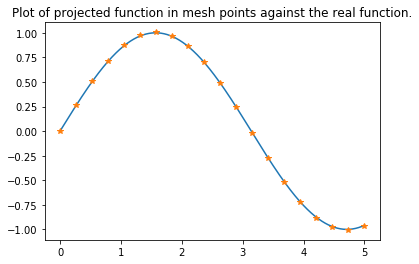

In [10]:
test_1d()

We get a rather small error for all the functions and we see that it decreses as the mesh size is increased.

We also get a plot which look much like the expected function.

### Results of tests in 2D

==== Test of the "norm per element" for some functions ====

======= NEW FUNCTION =======

f(x,y) = x^2 + y
====
mesh_size is approximately 5x5
error norm per element = 0.007810249675906673
====
mesh_size is approximately 7x7
error norm per element = 0.002563980182686478
====
mesh_size is approximately 10x10
error norm per element = 0.0007916120274019351

======= NEW FUNCTION =======

f(x,y) = x^3 + xy + y^2
====
mesh_size is approximately 5x5
error norm per element = 0.03479454886181854
====
mesh_size is approximately 7x7
error norm per element = 0.011630927724760818
====
mesh_size is approximately 10x10
error norm per element = 0.0034658783104276076

======= NEW FUNCTION =======

f(x,y) = sin(x + y)
====
mesh_size is approximately 5x5
error norm per element = 0.0063549060710927615
====
mesh_size is approximately 7x7
error norm per element = 0.002096186140137837
====
mesh_size is approximately 10x10
error norm per element = 0.000587314446397491


==== Example for the function f(x,y) =

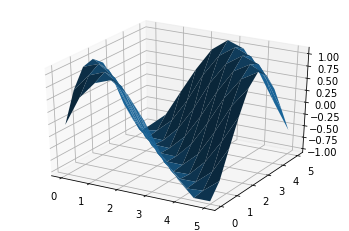

In [11]:
test_2d()

The errors behave just as in 1D and the so does the plot.

# **Discussion**

Just as expected the errors of the function approximations in both 1D and 2D decreased when the mesh size increased. This is intuitive since it will be easier to fit linear "bits" to a non-linear function if we have more of these bits to use.

The algorithms implemented use was not always the quickest and best. In cases it could be possible to calculate some values ahead analytically, insted of calculating them numerically. The implementations used gave good and realiable results, in comparison to some alternative methods tried and where therfore favored.